# Figure 2
- Identify TFs that target adhesome loci
- Study their activity and proximity in Hi-C

### Setup

In [1]:
# Import standard libraries
from importlib import reload
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import sparse
import scipy.stats as ss
import csv
import pandas as pd
import networkx as nx
import community
import pickle
from collections import defaultdict
import operator
from scipy.sparse import csr_matrix
import itertools
import os.path
import math
import pybedtools
import time
from tqdm import tqdm
import random
import OmicsIntegrator as oi
import gseapy
from gseapy.plot import barplot, dotplot
# Custom libraries
import utils as lu
import correlation_clustering as cc
# Reload modules in case of modifications
reload(lu)
reload(cc)

/home/louiscam/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


<module 'correlation_clustering' from '/home/louiscam/projects/gpcr/code/figures0/correlation_clustering.py'>

In [2]:
# Directory of adhesome data
dir_adhesome = '/home/louiscam/projects/gpcr/data/adhesome_data/'
# Directory of genome data
dir_genome = '/home/louiscam/projects/gpcr/data/genome_data/'
# Directory of processed HiC
dir_processed_hic = '/home/louiscam/projects/gpcr/save/processed_hic_data_dir/'
# Directory for storing preliminary results
prelim_results_dir = '/home/louiscam/projects/gpcr/save/prelim_results_dir/'
# Directory of epigenomic data
epigenome_dir = '/home/louiscam/projects/gpcr/data/epigenome_data/'
processed_epigenome_data_dir = '/home/louiscam/projects/gpcr/save/processed_epigenome_data_dir/'
# Saving directory
saving_dir = '/home/louiscam/projects/gpcr/save/figures/'

In [3]:
# Specify directories and relevant information
cell_type = 'IMR90'
resol_str = '250kb'
resol = 250000
quality = 'MAPQGE30'

### Import TF data

In [4]:
# Load TF-target data (TRRUST)
tf_df = pickle.load(open(dir_genome+'trrust_df.pkl', 'rb'))
all_tf_genes = np.unique(tf_df['TF'].values)
tf_df.head()

,TF,Target,Regulation,PMID
0,AATF,BAX,Repression,22909821
1,AATF,CDKN1A,Unknown,17157788
2,AATF,KLK3,Unknown,23146908
3,AATF,MYC,Activation,20549547
4,AATF,TP53,Unknown,17157788


In [5]:
# Load all/active/inactive loci
all_loci = pickle.load(open(saving_dir+'all_loci.pkl', 'rb'))
active_loci = pickle.load(open(saving_dir+'active_loci.pkl', 'rb'))
inactive_loci = pickle.load(open(saving_dir+'inactive_loci.pkl', 'rb'))

### Identify TFs that target adhesome genes

In [6]:
# Load all/active/inactive adhesome loci and genes
adhesome_loci_list = pickle.load(open(saving_dir+'adhesome_loci_list.pkl', 'rb'))
active_adhesome_loci = pickle.load(open(saving_dir+'active_adhesome_loci.pkl', 'rb'))
inactive_adhesome_loci = pickle.load(open(saving_dir+'inactive_adhesome_loci.pkl', 'rb'))
adhesome_genes_list = pickle.load(open(saving_dir+'adhesome_genes.pkl', 'rb'))
active_adhesome_genes = pickle.load(open(saving_dir+'active_adhesome_genes.pkl', 'rb'))
active_intrinsic_adhesome_genes = pickle.load(open(saving_dir+'active_intrinsic_adhesome_genes.pkl', 'rb'))
inactive_adhesome_genes = pickle.load(open(saving_dir+'inactive_adhesome_genes.pkl', 'rb'))
active_intrinsic_adhesome_genes = pickle.load(open(saving_dir+'active_intrinsic_adhesome_genes.pkl', 'rb'))
# Load all active/inactive loci
all_active_loci = pickle.load(open(saving_dir+'all_active_loci.pkl', 'rb'))
all_inactive_loci = pickle.load(open(saving_dir+'all_inactive_loci.pkl', 'rb'))

In [7]:
# TFs targeting adhesome loci
tf_adhesome_df = tf_df[tf_df['Target'].isin(adhesome_genes_list)]
tf_adhesome_df['is_target_active'] = [(target in active_adhesome_genes) for target in tf_adhesome_df['Target'].values]
tf_targeting_adhesome = np.unique(tf_adhesome_df['TF'].values)
tf_targeting_active_adhesome = np.unique(tf_adhesome_df[tf_adhesome_df['Target'].isin(active_adhesome_genes)]['TF'].values)
tf_targeting_active_intrinsic_adhesome = np.unique(tf_adhesome_df[tf_adhesome_df['Target'].isin(active_intrinsic_adhesome_genes)]['TF'].values)
tf_targeting_inactive_adhesome = np.unique(tf_adhesome_df[tf_adhesome_df['Target'].isin(inactive_adhesome_genes)]['TF'].values)
pickle.dump(tf_targeting_active_adhesome ,open(saving_dir+'tf_targeting_active_adhesome.pkl', 'wb'), protocol=pickle.HIGHEST_PROTOCOL)
pickle.dump(tf_targeting_active_intrinsic_adhesome ,open(saving_dir+'tf_targeting_active_intrinsic_adhesome.pkl', 'wb'), protocol=pickle.HIGHEST_PROTOCOL)
print('Number of TFs targeting adhesome genes = '+str(len(tf_targeting_adhesome)))
print('TFs targeting adhesome genes that are themselves adhesome genes = '+str(set(tf_targeting_adhesome).intersection(set(adhesome_genes_list))))
print('Number of TFs targeting active adhesome genes = '+str(len(tf_targeting_active_adhesome)))
print('Number of TFs targeting inactive adhesome genes = '+str(len(tf_targeting_inactive_adhesome)))
tf_adhesome_df.head()

Number of TFs targeting adhesome genes = 128
TFs targeting adhesome genes that are themselves adhesome genes = {'STAT3'}
Number of TFs targeting active adhesome genes = 124
Number of TFs targeting inactive adhesome genes = 13


,TF,Target,Regulation,PMID,is_target_active
48,APC,AKT1,Repression,15888491,True
69,AR,AKT1,Activation_Repression,11278645;20589722,True
133,AR,PTEN,Activation_Unknown,23418309;20729295;21532617,True
135,AR,PTPN1,Unknown,22282656,True
156,AR,VIM,Repression,18535113,True


### Regulation effects of adhesome-targeting loci

<Figure size 432x288 with 0 Axes>

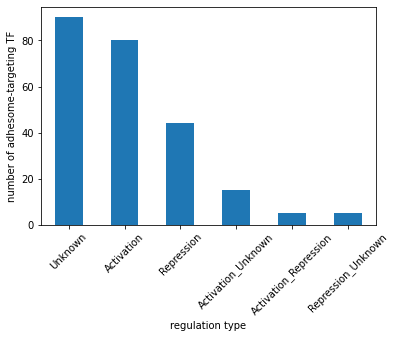

In [8]:
# Plot regulation type of adhesome TFs
plt.figure()
tf_adhesome_df.groupby('Regulation').count().reset_index().sort_values(by='Target', ascending=False).plot.bar(x='Regulation', y='Target', legend=None)
plt.xlabel('regulation type')
plt.ylabel('number of adhesome-targeting TF')
plt.xticks(rotation=45)
plt.show()

### Find the loci corresponding to adhesome-targeting TFs

In [9]:
# Load gene location in hg19
gene_locations_filename = dir_genome+'chrom_hg19.loc_canonical'
gene_id_filename = dir_genome+'chrom_hg19.name'
df_loc = lu.get_gene_locations(gene_locations_filename, gene_id_filename)

In [10]:
# Datframe with TF names
df_components = pd.DataFrame({'geneSymbol': tf_targeting_adhesome})
df_components.head()

,geneSymbol
0,APC
1,AR
2,ATF1
3,ATF2
4,ATM


In [11]:
# Find location of adhesome-targeting TF genes
tf_loc_df, missing_tf_genes = lu.get_adhesome_genes_location(df_components, df_loc)
tf_loc_df = lu.get_adhesome_genes_loci(tf_loc_df, resol)
tf_loc_df['chrom_int'] = tf_loc_df['chrom'].str.split('chr').str[1].astype(int)
tf_genes = np.unique(tf_loc_df['gene'])
print('Final number of TF genes = '+str(len(tf_genes)))
# Construct data frame annotating each adhesome locus with gene
tf_chr_loci = tf_loc_df[['chrom','chrom_int','loci','gene']]
tf_chr_loci = tf_chr_loci.sort_values(['chrom_int','loci'])
tf_loci = [tf_chr_loci.iloc[i]['chrom']+'_'+'loc'+str(tf_chr_loci.iloc[i]['loci']*resol) 
                 for i in range(len(tf_chr_loci))]
# Add locus ID column
tf_chr_loci['locus_id'] = ['chr_'+str(tf_chr_loci.iloc[i]['chrom_int'])+'_loc_'
                                 +str(tf_chr_loci.iloc[i]['loci']*resol) 
                                 for i in range(len(tf_chr_loci))]
tf_chr_loci['active'] = [locus in active_loci for locus in tf_chr_loci['locus_id']]
pickle.dump(tf_chr_loci ,open(saving_dir+'tf_chr_loci.pkl', 'wb'), protocol=pickle.HIGHEST_PROTOCOL)
# Visualize head of adhesome_chr_loci
print('Number of TF loci = '+str(len(tf_loci)))
tf_chr_loci.head()

Adhesome genes absent from UCSC genes: ['AR', 'KLF8', 'TAF1']
Final number of TF genes = 125
Number of TF loci = 160


/home/louiscam/projects/gpcr/code/figures0/utils.py:37: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  return df1.join(df.drop(explode, 1), how='left')


,chrom,chrom_int,loci,gene,locus_id,active
90,chr1,1,8,SKI,chr_1_loc_2000000,True
14,chr1,1,39,CTNNBIP1,chr_1_loc_9750000,True
86,chr1,1,100,RUNX3,chr_1_loc_25000000,True
86,chr1,1,101,RUNX3,chr_1_loc_25250000,True
34,chr1,1,131,HDAC1,chr_1_loc_32750000,True


In [28]:
# List of all adhesome-targeting TFs
tfs_targeting_adhesome_genes = np.unique(tf_chr_loci['gene'].values)
pickle.dump(tfs_targeting_adhesome_genes ,open(saving_dir+'tfs_targeting_adhesome_genes.pkl', 'wb'), protocol=pickle.HIGHEST_PROTOCOL)
tfs_targeting_adhesome_loci = np.unique(tf_chr_loci['locus_id'].values)
pickle.dump(tfs_targeting_adhesome_loci ,open(saving_dir+'tfs_targeting_adhesome_loci.pkl', 'wb'), protocol=pickle.HIGHEST_PROTOCOL)
active_tf_targeting_active_intrinsic_adhesome = [tf for tf in tf_targeting_active_intrinsic_adhesome
                                                 if tf in tf_chr_loci[tf_chr_loci['active']==True]['gene'].values]
pickle.dump(active_tf_targeting_active_intrinsic_adhesome ,open(saving_dir+'active_tf_targeting_active_intrinsic_adhesome.pkl', 'wb'), protocol=pickle.HIGHEST_PROTOCOL)

In [13]:
# Add TF activity to tf_adhesome_df
tf_adhesome_df = tf_adhesome_df[~tf_adhesome_df['TF'].isin(['KLF8', 'TAF1', 'AR'])]
tf_adhesome_df['is_tf_active'] = [(tf_chr_loci[tf_chr_loci['gene']==tf]['locus_id'].values[0] in all_active_loci) for tf in tf_adhesome_df['TF'].values]
tf_adhesome_df.head()

,TF,Target,Regulation,PMID,is_target_active,is_tf_active
48,APC,AKT1,Repression,15888491,True,True
228,ATF1,PLAUR,Unknown,12369939,True,True
250,ATF2,ITGB8,Unknown,21878622,True,True
358,ATM,PVR,Activation_Repression,21406724;21406724,True,True
396,BCL6,STAT3,Unknown,17951530,True,True


<Figure size 432x288 with 0 Axes>

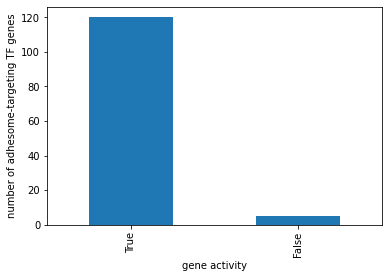

In [14]:
# Plot activity of adhesome-targeting TF genes
plt.figure()
tf_adhesome_df.drop_duplicates('TF').groupby('is_tf_active').count()
tf_adhesome_df.drop_duplicates('TF').groupby('is_tf_active').count().reset_index().sort_values(by='TF', ascending=False).plot.bar(x='is_tf_active', y='TF', legend=None)
plt.xlabel('gene activity')
plt.ylabel('number of adhesome-targeting TF genes')
plt.show()

In [15]:
# Plot adhesome-targeting TFs in the PCA/tSNE plots of all loci
df_clusters = pickle.load(open(saving_dir+'active_inactive_loci.pkl', 'rb'))
adhesome_tf_loci = np.unique(tf_chr_loci['locus_id'].values)
df_clusters['adhesome_tf_locus'] = 0
df_clusters.loc[adhesome_tf_loci,'adhesome_tf_locus'] = 1
df_clusters.head()

,H3K4me1,H3K4me2,H3K4me3,H3K36me3,H3K9ac,POLR2A,H3K9me3,H3K27me3,RNAseq,ATACseq,cluster,PC1,PC2,tSNE1,tSNE2,adhesome_locus,type,adhesome_tf_locus
chr_1_loc_0,-1.008735,-1.958933,-0.762508,-0.846516,-2.030991,-0.789470,-4.012477,-0.207024,-0.580582,-0.649909,0,3.604792,2.546615,-48.559505,18.347490,0,inactive,0
chr_1_loc_250000,-2.015639,-1.958933,-1.559915,-1.915456,-3.572735,-0.789470,-6.973887,-1.800421,-1.212921,-1.994005,0,7.062331,4.800447,-65.415192,7.989654,0,inactive,0
chr_1_loc_500000,-0.505283,-0.780395,-0.296056,0.502253,-1.408623,0.148832,-3.677000,-1.297760,0.481148,-1.994005,0,2.204047,2.981675,-42.624043,16.534678,0,inactive,0
chr_1_loc_750000,0.796121,0.903726,2.096163,1.085439,1.086720,3.123182,-0.596838,0.641495,1.608928,1.160163,1,-4.107282,1.795891,-8.953670,-84.428932,0,active,0
chr_1_loc_1000000,0.699133,0.629325,2.047202,0.909434,1.328125,2.327504,-0.485287,0.407424,1.932739,1.077385,1,-3.888290,1.491828,-9.167767,-81.599449,0,active,0


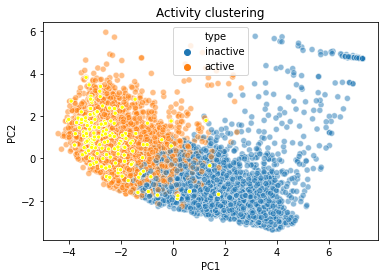

In [16]:
# Plot PC1 and PC2
%matplotlib inline
plt.figure()
sns.scatterplot(x="PC1", y="PC2", data=df_clusters, hue="type", alpha=0.5)
sns.scatterplot(x="PC1", y="PC2", data=df_clusters[df_clusters['adhesome_tf_locus']==1], 
                size=0.1, color='yellow',legend=False)
plt.title('Activity clustering')
plt.show()

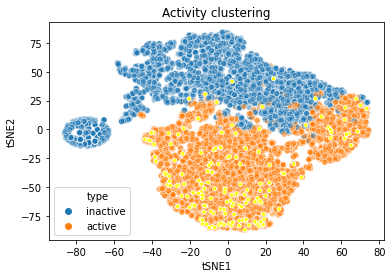

In [17]:
# Plot tSNE1 and tSNE2
%matplotlib inline
plt.figure()
sns.scatterplot(x="tSNE1", y="tSNE2", data=df_clusters, hue="type", alpha=0.5)
sns.scatterplot(x="tSNE1", y="tSNE2", data=df_clusters[df_clusters['adhesome_tf_locus']==1], 
                size=0.1, color='yellow',legend=False)
plt.title('Activity clustering')
plt.show()

### Add RNAseq information for each TF gene and target gene

In [18]:
# Load tf_loc
tf_loc = pickle.load(open(saving_dir+'tf_loc.pkl', 'rb'))
target_loc = pickle.load(open(saving_dir+'target_loc.pkl', 'rb'))

In [41]:
# Add RNAseq information to tf_adhesome_df
tf_adhesome_df['tfRNAseq'] = [tf_loc[tf_loc['gene']==tf]['normRNAseq'].values[0] for tf in tf_adhesome_df['TF'].values]
tf_adhesome_df['targetRNAseq'] = [target_loc[target_loc['gene']==target]['normRNAseq'].values[0] for target in tf_adhesome_df['Target'].values]
tf_adhesome_df.head()

,TF,Target,Regulation,PMID,is_target_active,is_tf_active,tfRNAseq,targetRNAseq
48,APC,AKT1,Repression,15888491,True,True,9.395377,12.100945
228,ATF1,PLAUR,Unknown,12369939,True,True,8.781036,12.055930
250,ATF2,ITGB8,Unknown,21878622,True,True,8.586265,7.123902
358,ATM,PVR,Activation_Repression,21406724;21406724,True,True,8.340918,12.608955
396,BCL6,STAT3,Unknown,17951530,True,True,8.397621,9.651958


In [42]:
# Restrict tf_adhesome_df to active TFs with active targets
tf_adhesome_df1 = tf_adhesome_df[(tf_adhesome_df['is_target_active']==True) & (tf_adhesome_df['is_tf_active']==True)]

In [43]:
# Create list of activating and repressing active TFs targeting active adhesome genes
activating_tfs = np.unique(tf_adhesome_df1[tf_adhesome_df1['Regulation']=='Activation']['TF'].values)
repressing_tfs = np.unique(tf_adhesome_df1[tf_adhesome_df1['Regulation']=='Repression']['TF'].values)
unknown_tfs = np.unique(tf_adhesome_df1[tf_adhesome_df1['Regulation']=='Unknown']['TF'].values)
activating_only_tfs = list(set(activating_tfs)-set(repressing_tfs))
repressing_only_tfs = list(set(repressing_tfs)-set(activating_tfs))
print('Number of activating TFs = '+str(len(activating_tfs)))
print('Number of repressing TFs = '+str(len(repressing_tfs)))
print('Number of activating-only TFs = '+str(len(activating_only_tfs)))
print('Number of repressing-only TFs = '+str(len(repressing_only_tfs)))

Number of activating TFs = 46
Number of repressing TFs = 37
Number of activating-only TFs = 36
Number of repressing-only TFs = 27


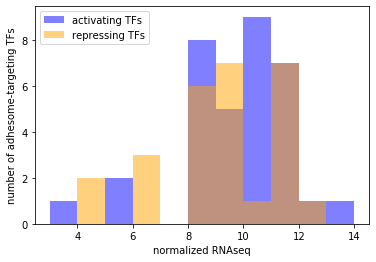

In [44]:
# Distribution of RNAseq among activating and repressing adhesome-targeting TFs
plt.figure()
plt.hist(tf_loc[tf_loc['gene'].isin(activating_only_tfs)]['normRNAseq'].values, 
         bins=np.arange(3,15,1), color='blue', alpha=0.5, label='activating TFs')
plt.hist(tf_loc[tf_loc['gene'].isin(repressing_only_tfs)]['normRNAseq'].values, 
         bins=np.arange(3,15,1), color='orange', alpha=0.5, label='repressing TFs')
#plt.hist(tf_loc[tf_loc['gene'].isin(set(unknown_tfs)-set(activating_tfs)-set(repressing_tfs))]['normRNAseq'].values, 
#         bins=np.arange(0,15,1), color='green', alpha=0.5, label='unknown TFs')
plt.xlabel('normalized RNAseq')
plt.ylabel('number of adhesome-targeting TFs')
plt.legend()
plt.show()

In [45]:
# Identify highly expressed activating and repressing TFs
expression_threshold = 8
high_activating_tfs = np.unique(tf_adhesome_df1[(tf_adhesome_df1['tfRNAseq']>8) & (tf_adhesome_df1['Regulation']=='Activation')]['TF'].values)
high_repressing_tfs = np.unique(tf_adhesome_df1[(tf_adhesome_df1['tfRNAseq']>8) & (tf_adhesome_df1['Regulation']=='Repression')]['TF'].values)

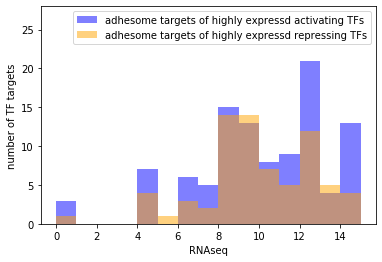

In [46]:
# RNAseq expression of TF targets
plt.figure()
plt.hist(tf_adhesome_df1[tf_adhesome_df1['TF'].isin(high_activating_tfs)]['targetRNAseq'].values,
        bins=np.arange(0,16,1), color='blue', alpha=0.5, label='adhesome targets of highly expressd activating TFs')
plt.hist(tf_adhesome_df1[tf_adhesome_df1['TF'].isin(high_repressing_tfs)]['targetRNAseq'].values,
        bins=np.arange(0,16,1), color='orange', alpha=0.5, label='adhesome targets of highly expressd repressing TFs')
plt.xlabel('RNAseq')
plt.ylabel('number of TF targets')
plt.ylim(0,28)
plt.legend()
plt.show()

### Proximity of adhesome-targeting TFs in Hi-C

In [47]:
# List of all active TFs targeting adhesome genes
active_tfs_targeting_adhesome_loci = np.array([locus for locus in tfs_targeting_adhesome_loci if (locus in all_active_loci)])
active_tfs_targeting_adhesome_loci = active_tfs_targeting_adhesome_loci[np.argsort([int(locus.split('_')[1]) for locus in active_tfs_targeting_adhesome_loci])]
number_tfs_per_chrom = {chrom: len([locus for locus in active_tfs_targeting_adhesome_loci if (int(locus.split('_')[1])==chrom)])
                                  for chrom in np.arange(1,22+1,1)}

In [48]:
# Create a dictionary of all non-adhesome, non adhesome-targeting TF active loci for each chromosome
all_active_loci_without_adhesome = list(set(active_loci) - set(active_tfs_targeting_adhesome_loci)-set(active_adhesome_loci))
active_loci_pool = {chrom: [locus for locus in all_active_loci_without_adhesome if (int(locus.split('_')[1])==chrom)] 
                    for chrom in np.arange(1,22+1,1)}

In [49]:
# Create list out of all adhesome and random groups of loci (sorted by chromosome)
random_active_non_adhesome_TF_loci = np.array(pickle.load(open(saving_dir+'random_active_non_adhesome_TF_loci.pkl', 'rb')))
loci_list = list(itertools.chain.from_iterable([active_tfs_targeting_adhesome_loci,
                                                random_active_non_adhesome_TF_loci]))

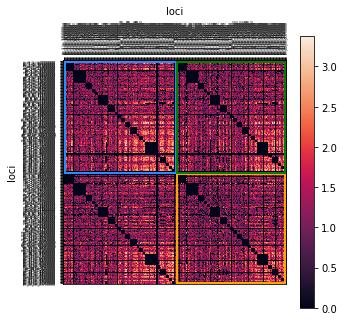

In [50]:
# Load contacts_df1_tf
contacts_df1_tf = pickle.load(open(saving_dir+'contacts_df1_tf.pkl', 'rb'))
# Plot data frame as heatmap
patches_list = [[2,2,len(active_tfs_targeting_adhesome_loci)-1, len(active_tfs_targeting_adhesome_loci)-1,'dodgerblue'],
                [len(active_tfs_targeting_adhesome_loci)+2,len(active_tfs_targeting_adhesome_loci)+2,len(random_active_non_adhesome_TF_loci)-4,len(random_active_non_adhesome_TF_loci)-3,'orange'],
                [len(active_tfs_targeting_adhesome_loci)+2, 2,len(random_active_non_adhesome_TF_loci)-4,len(active_tfs_targeting_adhesome_loci)-1,'green']]
lu.plot_heatmap(contacts_df1_tf, loci_list, loci_list, 'loci', 'loci', 
                5, contacts_df1_tf.max().max(), add_patches = patches_list)

Note: There is no fundamental difference between the four quadrants. Note that in all quadrants, there seems to be higher HiC contact among the last few chromosomes. We showed that there is in general a higher contact betwen the last chromosomes in Figure 1.

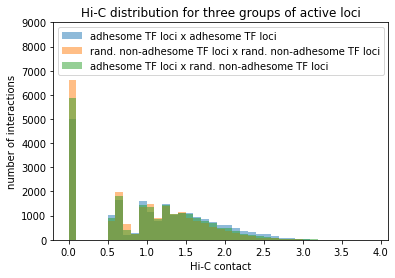

In [51]:
# Histogram of average Hi-C contacts in three active cases
# Group of active adhesome TF loci with itself
active_adhesome_tf_hic_with_itself = contacts_df1_tf.loc[active_tfs_targeting_adhesome_loci,active_tfs_targeting_adhesome_loci].values.flatten()
# Group of random active non-adhesome loci with itself
random_active_adhesome_TF_hic_with_itself = contacts_df1_tf.loc[random_active_non_adhesome_TF_loci,random_active_non_adhesome_TF_loci].values.flatten()
# Group of random active non-adhesome loci with active adhesome loci
random_versus_adhesome_TF_active = contacts_df1_tf.loc[active_tfs_targeting_adhesome_loci,random_active_non_adhesome_TF_loci].values.flatten()
# Histogram
plt.figure()
plt.hist(active_adhesome_tf_hic_with_itself, 
         bins = np.arange(0,4,0.1), alpha=0.5, density=False, label='adhesome TF loci x adhesome TF loci')
plt.hist(random_active_adhesome_TF_hic_with_itself, 
         bins = np.arange(0,4,0.1), alpha=0.5, density=False, label='rand. non-adhesome TF loci x rand. non-adhesome TF loci')
plt.hist(random_versus_adhesome_TF_active, 
         bins = np.arange(0,4,0.1), alpha=0.5, density=False, label='adhesome TF loci x rand. non-adhesome TF loci')
plt.xlabel('Hi-C contact')
plt.ylabel('number of interactions')
plt.title('Hi-C distribution for three groups of active loci')
plt.legend(loc='upper left')
plt.ylim(0,9000)
plt.show()

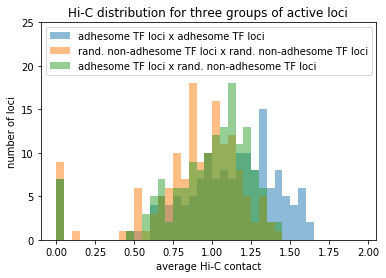

Wilcoxon Rank-Sums test:
RanksumsResult(statistic=5.609356731671094, pvalue=2.0308003378730824e-08)


In [52]:
# Histogram of average Hi-C contacts in three active cases
# Group of active adhesome TF loci with itself
active_adhesome_tf_hic_with_itself = contacts_df1_tf.loc[active_tfs_targeting_adhesome_loci,active_tfs_targeting_adhesome_loci].mean(axis=1)
# Group of random active non-adhesome loci with itself
random_active_adhesome_TF_hic_with_itself = contacts_df1_tf.loc[random_active_non_adhesome_TF_loci,random_active_non_adhesome_TF_loci].mean(axis=1)
# Group of random active non-adhesome loci with active adhesome loci
random_versus_adhesome_TF_active = contacts_df1_tf.loc[active_tfs_targeting_adhesome_loci,random_active_non_adhesome_TF_loci].mean(axis=1)
# Histogram
plt.figure()
plt.hist(active_adhesome_tf_hic_with_itself, 
         bins=np.arange(0,2,0.05), alpha=0.5, density=False, label='adhesome TF loci x adhesome TF loci')
plt.hist(random_active_adhesome_TF_hic_with_itself, 
         bins=np.arange(0,2,0.05), alpha=0.5, density=False, label='rand. non-adhesome TF loci x rand. non-adhesome TF loci')
plt.hist(random_versus_adhesome_TF_active, 
         bins=np.arange(0,2,0.05), alpha=0.5, density=False, label='adhesome TF loci x rand. non-adhesome TF loci')
plt.xlabel('average Hi-C contact')
plt.ylabel('number of loci')
plt.title('Hi-C distribution for three groups of active loci')
plt.ylim(0,25)
plt.legend(loc='upper left')
plt.show()
print('Wilcoxon Rank-Sums test:')
print(ss.ranksums(active_adhesome_tf_hic_with_itself.values,
                  random_active_adhesome_TF_hic_with_itself))

### Proximity of adhesome-targeting TFs and adhesome genes in Hi-C

In [53]:
# List of all active adhesome genes
active_adhesome_loci = pickle.load(open(saving_dir+'active_adhesome_loci.pkl', 'rb'))
number_adhesome_per_chrom = {chrom: len([locus for locus in active_adhesome_loci if (int(locus.split('_')[1])==chrom)])
                                  for chrom in np.arange(1,22+1,1)}

In [54]:
# Create list out of all adhesome loci, random loci and adhesome TF loci
random_active_non_adhesome_loci = pickle.load(open(saving_dir+'random_active_non_adhesome_loci.pkl', 'rb'))
loci_list = list(itertools.chain.from_iterable([active_tfs_targeting_adhesome_loci,
                                                active_adhesome_loci,
                                                random_active_non_adhesome_loci]))

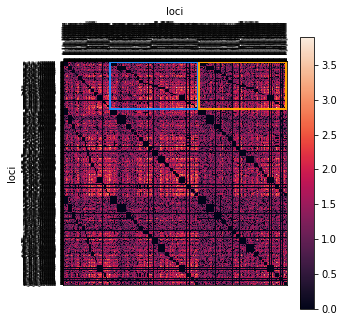

In [55]:
# Load contacts_df2_tf
contacts_df2_tf = pickle.load(open(saving_dir+'contacts_df2_tf.pkl', 'rb'))
# Plot data frame as heatmap
patches_list = [[len(active_tfs_targeting_adhesome_loci),2,len(active_adhesome_loci)-2,len(active_tfs_targeting_adhesome_loci),'dodgerblue'],
                [2+len(active_tfs_targeting_adhesome_loci)+len(active_adhesome_loci),2,len(random_active_non_adhesome_loci)-3,len(active_tfs_targeting_adhesome_loci),'orange']]
lu.plot_heatmap(contacts_df2_tf, loci_list, loci_list, 'loci', 'loci', 
                5, contacts_df2_tf.max().max(), add_patches=patches_list)

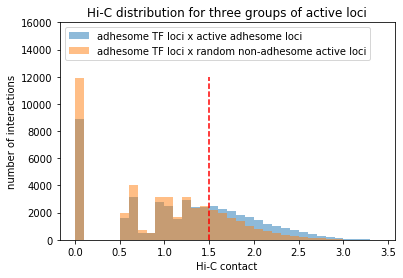

In [56]:
# Histogram of average Hi-C contacts in three active cases
# Group of active adhesome TF loci with active adhesome loci
active_adhesome_tf_hic_with_adhesome_loci = contacts_df2_tf.loc[active_tfs_targeting_adhesome_loci,active_adhesome_loci].values.flatten()
# Group of active adhesome TF loci with random active non-adhesome loci
active_adhesome_tf_hic_with_random_loci = contacts_df2_tf.loc[active_tfs_targeting_adhesome_loci,random_active_non_adhesome_loci].values.flatten()
# Histogram
plt.figure()
plt.hist(active_adhesome_tf_hic_with_adhesome_loci, 
         bins=np.arange(0,3.5,0.1), alpha=0.5, density=False, label='adhesome TF loci x active adhesome loci')
plt.hist(active_adhesome_tf_hic_with_random_loci, 
         bins=np.arange(0,3.5,0.1), alpha=0.5, density=False, label='adhesome TF loci x random non-adhesome active loci')
plt.vlines(x=1.5, ymin=0, ymax=12000, color='red', linestyle='dashed')
plt.xlabel('Hi-C contact')
plt.ylabel('number of interactions')
plt.title('Hi-C distribution for three groups of active loci')
plt.ylim(0,16000)
plt.legend(loc='upper left')
plt.show()

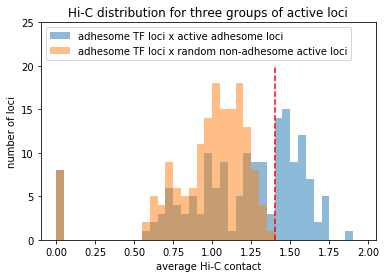

Wilcoxon Rank-Sums test:
RanksumsResult(statistic=6.821459352096713, pvalue=9.012027033815651e-12)


In [57]:
# Histogram of average Hi-C contacts in three active cases
# Group of active adhesome TF loci with active adhesome loci
active_adhesome_tf_hic_with_adhesome_loci = contacts_df2_tf.loc[active_tfs_targeting_adhesome_loci,active_adhesome_loci].mean(axis=1)
# Group of active adhesome TF loci with random active non-adhesome loci
active_adhesome_tf_hic_with_random_loci = contacts_df2_tf.loc[active_tfs_targeting_adhesome_loci,random_active_non_adhesome_loci].mean(axis=1)
# Histogram
plt.figure()
plt.hist(active_adhesome_tf_hic_with_adhesome_loci, 
         bins=np.arange(0,2,0.05), alpha=0.5, density=False, label='adhesome TF loci x active adhesome loci')
plt.hist(active_adhesome_tf_hic_with_random_loci, 
         bins=np.arange(0,2,0.05), alpha=0.5, density=False, label='adhesome TF loci x random non-adhesome active loci')
plt.vlines(x=1.4, ymin=0, ymax=20, color='red', linestyle='dashed')
plt.xlabel('average Hi-C contact')
plt.ylabel('number of loci')
plt.title('Hi-C distribution for three groups of active loci')
plt.ylim(0,25)
plt.legend(loc='upper left')
plt.show()
print('Wilcoxon Rank-Sums test:')
print(ss.ranksums(active_adhesome_tf_hic_with_adhesome_loci.values,
                  active_adhesome_tf_hic_with_random_loci))

In [58]:
# List of important adhesome-targeting TFs
avg_hic_with_adhesome = contacts_df2_tf.loc[active_tfs_targeting_adhesome_loci,active_adhesome_loci].mean(axis=1)
avg_hic_with_adhesome_df = pd.DataFrame(avg_hic_with_adhesome.sort_values(ascending=False), columns=['avg_hic'])
selected_tf_loci_df = avg_hic_with_adhesome_df[avg_hic_with_adhesome_df['avg_hic']>1.4]
print('Total number of important TF loci = '+str(len(selected_tf_loci_df)))
# Add gene information
selected_tf_loci_df['tf_genes'] = [tf_chr_loci[tf_chr_loci['locus_id']==selected_tf_loci_df.index[i]]['gene'].values 
                                  for i in range(len(selected_tf_loci_df))]
selected_tf_genes_df = lu.unnesting(selected_tf_loci_df, ['tf_genes'])
selected_tf_genes_df = selected_tf_genes_df.drop_duplicates(subset=['tf_genes'])
selected_tf_genes_df = selected_tf_genes_df.sort_values('avg_hic', ascending=False)
print('Total number of important TF genes = '+str(len(selected_tf_genes_df)))
important_tf_genes = selected_tf_genes_df['tf_genes'].values
print(important_tf_genes)

Total number of important TF loci = 65
Total number of important TF genes = 47
['TFDP1' 'PKNOX1' 'SREBF2' 'E2F1' 'MEN1' 'CTCF' 'CEBPB' 'SP1' 'FOS' 'JUND'
 'KAT5' 'RELA' 'MAZ' 'GLI1' 'NFIC' 'EGR1' 'BRCA1' 'RFX1' 'FOSL1' 'ETV4'
 'RARA' 'ATF1' 'RUNX3' 'HNF1A' 'CTNNBIP1' 'RUNX1' 'DNMT1' 'STAT3' 'NAB2'
 'STAT6' 'TP53' 'SALL4' 'PPARA' 'SP2' 'SPI1' 'HDGF' 'HMGA1' 'HNF4A'
 'PIAS3' 'HIPK2' 'PAX5' 'ZNF148' 'SPDEF' 'HIC1' 'ESR2' 'RXRA' 'MTA1']


### Cluster network of adhesome genes + adhesome TFs
- Select adhesome TF loci
- Create TF-adhesome genes network from interX and intraX data
- Cluster with VOTE+BOEM

In [59]:
# Load adhesome_chr_loci
adhesome_chr_loci = pickle.load(open(saving_dir+'adhesome_chr_loci.pkl', 'rb'))
adh_tf_chr_loci = pd.concat([adhesome_chr_loci,tf_chr_loci])
pickle.dump(adh_tf_chr_loci, open(saving_dir+'adh_tf_chr_loci.pkl', 'wb'))

# Dictionary with locus as key and gene as value
adh_tf_chr_loci_bis = adh_tf_chr_loci.groupby('locus_id')['gene'].apply(lambda x: '_'.join(x)).reset_index()
adh_tf_locus_gene_dict = {adh_tf_chr_loci_bis.iloc[i,0]:adh_tf_chr_loci_bis.iloc[i,1] 
                            for i in np.arange(len(adh_tf_chr_loci_bis))}
pickle.dump(adh_tf_locus_gene_dict, open(saving_dir+'adh_tf_locus_gene_dict.pkl', 'wb'))

# Dictionary with gene as key and locus as value
adh_tf_chr_loci_ter = adh_tf_chr_loci.groupby('gene')['locus_id'].apply(lambda x: '_x_'.join(x)).reset_index()
adh_tf_gene_locus_dict = {adh_tf_chr_loci_ter.iloc[i,0]:adh_tf_chr_loci_ter.iloc[i,1] 
                            for i in np.arange(len(adh_tf_chr_loci_ter))}
pickle.dump(adh_tf_gene_locus_dict, open(saving_dir+'adh_tf_gene_locus_dict.pkl', 'wb'))


# Select TF loci and adhesome loci
selected_tf_loci = active_tfs_targeting_adhesome_loci
selected_loci = np.unique(np.concatenate([selected_tf_loci, active_adhesome_loci]))

Number of interX edges = 48440


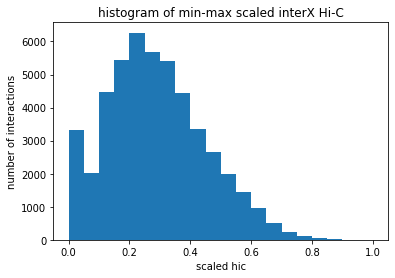

In [45]:
# Build interX edge list
selected_interX_edge_list = cc.create_interX_edgelist(contacts_df2_tf, selected_loci, adh_tf_locus_gene_dict)
pickle.dump(selected_interX_edge_list, open(saving_dir+'selected_interX_edge_list.pkl', 'wb'))
print('Number of interX edges = '+str(len(selected_interX_edge_list)))

# Histogram of interX contacts
plt.figure()
plt.hist(selected_interX_edge_list['scaled_hic'].values, bins=np.arange(0,1.05,0.05))
plt.xlabel('scaled hic')
plt.ylabel('number of interactions')
plt.title('histogram of min-max scaled interX Hi-C')
plt.show()

100%|██████████| 21/21 [00:17<00:00,  1.19it/s]

2515


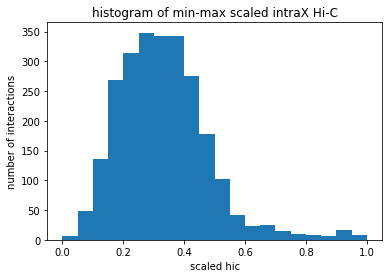

In [46]:
# Build intraX edge list
selected_intraX_edge_list = cc.create_intraX_edgelist(selected_loci, adh_tf_locus_gene_dict, df_loc, resol, dir_processed_hic)
pickle.dump(selected_intraX_edge_list, open(saving_dir+'selected_intraX_edge_list.pkl', 'wb'))
print(len(selected_intraX_edge_list))

# Histogram of intraX contacts
plt.figure()
plt.hist(selected_intraX_edge_list['scaled_hic'].values, bins=np.arange(0,1.05,0.05))
plt.xlabel('scaled hic')
plt.ylabel('number of interactions')
plt.title('histogram of min-max scaled intraX Hi-C')
plt.show()

In [82]:
# Combine intraX and interX edge lists
selected_interX_edge_list = pickle.load(open(saving_dir+'selected_interX_edge_list.pkl', 'rb'))
selected_intraX_edge_list = pickle.load(open(saving_dir+'selected_intraX_edge_list.pkl', 'rb'))
adh_tf_edge_list = pd.concat([selected_intraX_edge_list[['source','target','hic','scaled_hic']],
                              selected_interX_edge_list])
adh_tf_edge_list = adh_tf_edge_list[adh_tf_edge_list['scaled_hic']>0.62]
adh_tf_edge_list = adh_tf_edge_list.sort_values(by=['source','target'])
adh_tf_edge_list = adh_tf_edge_list[adh_tf_edge_list['source']!=adh_tf_edge_list['target']]
print(len(adh_tf_edge_list))
adh_tf_edge_list.head()

1571


,source,target,hic,scaled_hic
382,ABI3,ABL1,2.699883,0.646918
414,ABI3,DNM2,2.820304,0.682309
1,ABI3,ITGA3,7.160237,0.714434
473,ABI3,MAPK1,2.713517,0.650924
484,ABI3,NFIC,2.992940,0.733047


In [83]:
# Create corresponding network
G = nx.from_pandas_edgelist(adh_tf_edge_list, edge_attr=['hic','scaled_hic'])
G.add_nodes_from(np.unique(adh_tf_chr_loci[adh_tf_chr_loci['active']==True]['gene']))
print('Total number of nodes in G = '+str(len(G.nodes)))
print('Total number of edges in G = '+str(len(G.edges)))
print('Average node degree in G = '+str(np.mean(list(dict(G.degree).values()))))
print('Number of connected components in G = '+str(nx.number_connected_components(G)))
print('Size of connected components = '+str([len(c) for c in nx.connected_components(G)]))
#pickle.dump(G, open('graph_adh_tf.pkl', 'wb'))

Total number of nodes in G = 339
Total number of edges in G = 1571
Average node degree in G = 9.268436578171091
Number of connected components in G = 149
Size of connected components = [167, 2, 3, 4, 2, 3, 2, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


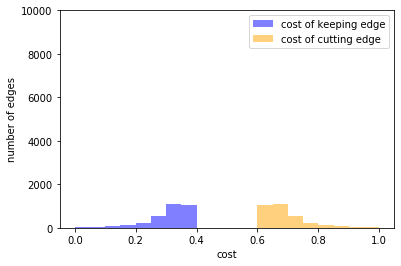

In [84]:
# Get cost matrices for VOTE/BOEM
A, w_plus, w_minus, w_pm = cc.compute_costs(G, 'scaled_hic')
n = G.number_of_nodes()
# Plot histogram of costs
plt.figure()
plt.hist(w_minus[np.nonzero(w_plus)], bins=np.arange(0,1.05,0.05), 
         color='blue', alpha=0.5, label='cost of keeping edge')
plt.hist(w_plus[np.nonzero(w_plus)], bins=np.arange(0,1.05,0.05), 
         color='orange', alpha=0.5, label='cost of cutting edge')
plt.ylim(0,10000)
plt.xlabel('cost')
plt.ylabel('number of edges')
plt.legend()
plt.show()

100%|██████████| 100/100 [00:24<00:00,  4.10it/s]


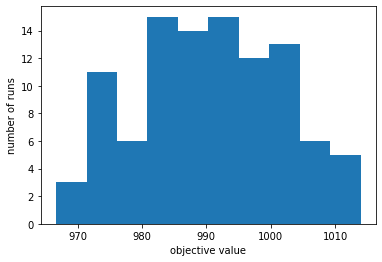

In [85]:
# Run VOTE
vote_dict, objective_vals = cc.VOTE(n, w_minus, w_plus, w_pm, n_runs=100, seed=13)
# Histogram of objectives from the runs
plt.figure()
plt.hist(objective_vals)
plt.xlabel('objective value')
plt.ylabel('number of runs')
plt.show()

In [ ]:
# Run BOEM
boem_dict = cc.BOEM(vote_dict, G.number_of_nodes(), w_minus, w_plus, max_iter=100)
pickle.dump(boem_dict, open('boem_dict_with_tf.pkl', 'wb'))

  0%|          | 0/339 [00:00<?, ?it/s]

VOTE objective = 966.6636867076954


  0%|          | 0/339 [00:00<?, ?it/s]

VOTE+BOEM 1 objective = 964.7773867902424


  0%|          | 0/339 [00:00<?, ?it/s]

VOTE+BOEM 2 objective = 963.0613210447948


  0%|          | 0/339 [00:00<?, ?it/s]

VOTE+BOEM 3 objective = 962.1828909446875


  0%|          | 0/339 [00:00<?, ?it/s]

VOTE+BOEM 4 objective = 961.3466626242094


  0%|          | 0/339 [00:00<?, ?it/s]

VOTE+BOEM 5 objective = 960.51196405698


  0%|          | 0/339 [00:00<?, ?it/s]

VOTE+BOEM 6 objective = 959.5487521746944


  0%|          | 0/339 [00:00<?, ?it/s]

VOTE+BOEM 7 objective = 958.0419533300187


  0%|          | 0/339 [00:00<?, ?it/s]

VOTE+BOEM 8 objective = 957.4548939393052


  0%|          | 0/339 [00:00<?, ?it/s]

VOTE+BOEM 9 objective = 956.9180421699397


  0%|          | 0/339 [00:00<?, ?it/s]

VOTE+BOEM 10 objective = 955.912559793496


  0%|          | 0/339 [00:00<?, ?it/s]

VOTE+BOEM 11 objective = 955.4837127383206


  0%|          | 0/339 [00:00<?, ?it/s]

VOTE+BOEM 12 objective = 955.0955404263965


  0%|          | 0/339 [00:00<?, ?it/s]

VOTE+BOEM 13 objective = 954.7518833841054


  0%|          | 0/339 [00:00<?, ?it/s]

VOTE+BOEM 14 objective = 954.463282205541


  0%|          | 0/339 [00:00<?, ?it/s]

VOTE+BOEM 15 objective = 954.2162418987414


  0%|          | 0/339 [00:00<?, ?it/s]

VOTE+BOEM 16 objective = 953.8413285736399


  0%|          | 0/339 [00:00<?, ?it/s]

VOTE+BOEM 17 objective = 953.478715042435


  0%|          | 0/339 [00:00<?, ?it/s]

VOTE+BOEM 18 objective = 953.1977265213569


  0%|          | 0/339 [00:00<?, ?it/s]

VOTE+BOEM 19 objective = 953.0390000634567


  0%|          | 0/339 [00:00<?, ?it/s]

VOTE+BOEM 20 objective = 952.8946885729904


  0%|          | 0/339 [00:00<?, ?it/s]

VOTE+BOEM 21 objective = 952.6371129509104


  0%|          | 0/339 [00:00<?, ?it/s]

VOTE+BOEM 22 objective = 952.5654794094886


 34%|███▎      | 114/339 [01:24<02:45,  1.36it/s]

In [57]:
# Load results
best_dict = pickle.load(open('boem_dict_with_tf.pkl', 'rb'))
print('Final VOTE/BOEM objective = '+str(cc.compute_objective_from_dict(best_dict, w_minus, w_plus)))

Final VOTE/BOEM objective = 966.6209132951719


In [58]:
# Result of VOTE+BOEM
k = len(np.unique(list(best_dict.values())))
c_mat = np.matrix(np.concatenate([np.eye(1,k,best_dict[i]) for i in range(n)],axis=0))
x_boem = np.array(c_mat*np.transpose(c_mat))
labels = list(G.nodes)
x_df = pd.DataFrame(x_boem, index=labels, columns=labels)

In [71]:
# Final clique graph
np.fill_diagonal(x_df.values, 0)
clique_graph = nx.from_pandas_adjacency(x_df)
# Add cluster information for each node
nx.set_node_attributes(clique_graph, {labels[i]: str(int(best_dict[i])) for i in range(n)}, "cluster")
# Add chromosome information for each node
nx.set_node_attributes(clique_graph, {labels[i]: adh_tf_chr_loci[adh_tf_chr_loci['gene']==labels[i]]['chrom'].values[0] for i in range(n)}, "chromosome")
# Add TF information for each node
nx.set_node_attributes(clique_graph, {labels[i]: 'adh_tf' if ((labels[i] in tf_targeting_adhesome) and (labels[i] in adhesome_genes_list)) 
                                      else 'tf' if (labels[i] in tf_targeting_adhesome)
                                      else 'adh'
                                      for i in range(n)}, "type")
# Add scaled HiC information
edgelist_clique = list(clique_graph.edges)
nx.set_edge_attributes(clique_graph, 
                       {edge: G[edge[0]][edge[1]]['scaled_hic'] for edge in G.edges}, 
                       'scaled_hic')
nx.set_edge_attributes(clique_graph, 
                       {edge: 1-G[edge[0]][edge[1]]['scaled_hic'] for edge in G.edges}, 
                       'reciprocal_scaled_hic')

In [78]:
# Clique graph summary
print('Total number of nodes in clique_graph = '+str(len(clique_graph.nodes)))
print('Total number of edges in clique_graph = '+str(len(clique_graph.edges)))
print('Average node degree in clique_graph = '+str(np.mean(list(dict(clique_graph.degree).values()))))
print('Number of connected components in clique_graph = '+str(nx.number_connected_components(clique_graph)))
print('Size of connected components = '+str(sorted([len(c) for c in nx.connected_components(clique_graph)], reverse=True)))
print('Number of nodes in non trivial cliques = '+str(sum([len(c) for c in nx.connected_components(clique_graph) if len(c)>1])))
# Save network to html
oi.output_networkx_graph_as_interactive_html(clique_graph, filename=saving_dir+"clique_graph_with_tf.html")

Total number of nodes in clique_graph = 346
Total number of edges in clique_graph = 353
Average node degree in clique_graph = 2.040462427745665
Number of connected components in clique_graph = 237
Size of connected components = [22, 5, 5, 5, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Number of nodes in non trivial cliques = 174


PosixPath('/home/louiscam/projects/gpcr/save/figures/clique_graph_with_tf.html')

In [79]:
# Select only components with more than 1 node
selected_nodes = np.sum([list(cc) for cc in nx.connected_components(clique_graph) if len(cc)>1])
clique_subgraph = clique_graph.subgraph(selected_nodes)
# Save network to html
oi.output_networkx_graph_as_interactive_html(clique_subgraph, filename=saving_dir+"clique_subgraph_with_tf.html")

PosixPath('/home/louiscam/projects/gpcr/save/figures/clique_subgraph_with_tf.html')

In [80]:
# Nodes in big component
nodes_in_big_component = list(list(nx.connected_components(clique_graph))[2])
np.array(sorted(nodes_in_big_component))

array(['DNM2', 'GRB2', 'ITGB4', 'MEN1'], dtype='<U5')

### Link TFs to Figure 1 clusters

In [50]:
# Load clusters from Figure 1 and select clusters with more than 1 node
clusters_fig1 = pickle.load(open(saving_dir+'clusters_fig1.pkl', 'rb'))
clusters_list = list(clusters_fig1[clusters_fig1['n_genes']>1].index)

In [ ]:
network_nodes_df = oi.get_network_as_data_frame_of_nodes(clique_graph)
selected_tf_genes = network_nodes_df[network_nodes_df['type']!='adh']['']

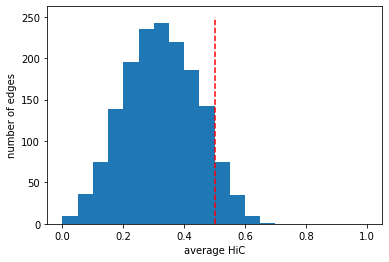

In [51]:
# Create bipartite edge list
tf_cluster_adjacency = pd.DataFrame(0, index=important_tf_genes, columns=clusters_list)
for tf_gene in important_tf_genes:
    for c in clusters_list:
        tf_cluster_adjacency.loc[tf_gene,c] = np.mean([G[tf_gene][adhesome_gene]['scaled_hic'] if adhesome_gene in G[tf_gene] 
                                                       else 0
                                                       for adhesome_gene in clusters_fig1.loc[c,'gene']])
tf_cluster_edge_list = tf_cluster_adjacency.stack().reset_index()
tf_cluster_edge_list.columns = ['source','target','avg_hic']
# Plot histogram of avg_hic between TFs and clusters
plt.figure()
plt.hist(tf_cluster_edge_list['avg_hic'].values, bins=np.arange(0,1.05,0.05))
plt.vlines(x=0.5, ymin=0, ymax=250, color='red', linestyle='dashed')
plt.xlabel('average HiC')
plt.ylabel('number of edges')
plt.show()
# Select top edges
tf_cluster_edge_list_pruned = tf_cluster_edge_list[tf_cluster_edge_list['avg_hic']>0.5]

In [52]:
# Create bipartite graph
G1 = nx.Graph()
G1.add_nodes_from(important_tf_genes, bipartite=0)
G1.add_nodes_from(list(clusters_fig1.index), bipartite=1)
G1.add_edges_from(nx.from_pandas_edgelist(tf_cluster_edge_list_pruned, edge_attr=['avg_hic']).edges(data=True))

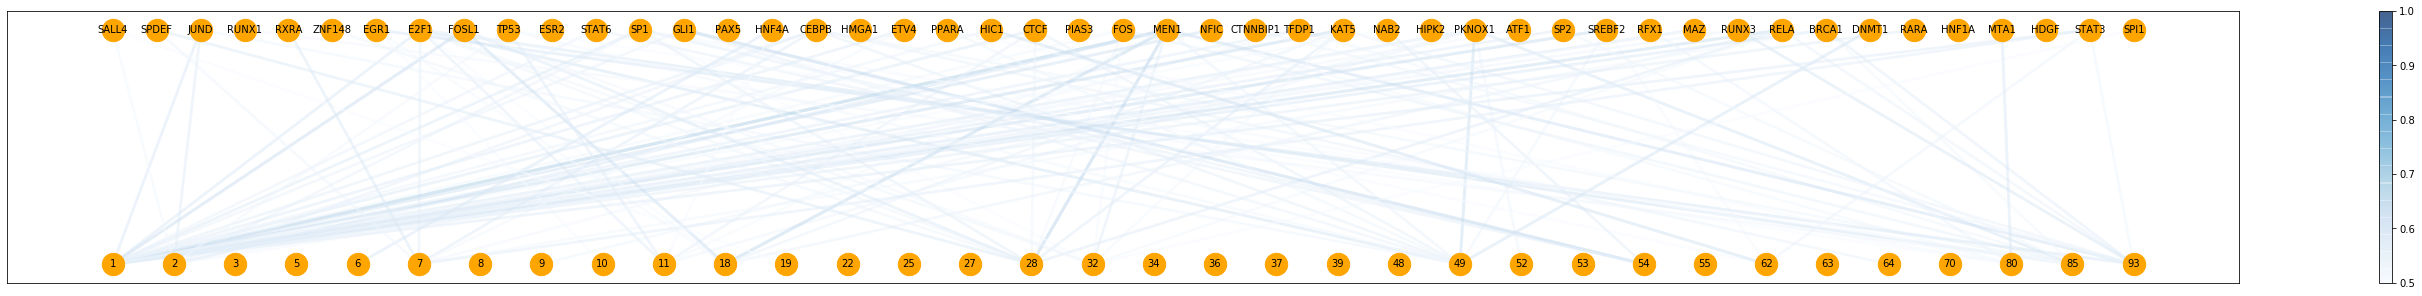

In [53]:
# Plot bipartite graph
plt.figure(figsize=(50,5))
pos = nx.drawing.layout.bipartite_layout(G1, important_tf_genes, align='horizontal')

# Plot nodes
nodes = nx.draw_networkx_nodes(G1, pos, 
                               node_size=500, node_color='orange')
nx.draw_networkx_labels(G1, pos, font_size=10)

# Plot edges
edges = nx.draw_networkx_edges(G1, pos, 
                               width = 5*np.array(list(nx.get_edge_attributes(G1,'avg_hic').values())),
                               edge_cmap=plt.cm.Blues,
                               edge_color = np.array(list(nx.get_edge_attributes(G1,'avg_hic').values())),
                               edge_vmin=0.5, edge_vmax=1, alpha=0.5)

plt.colorbar(edges)
plt.show()

### Analyze densely connected adhesome TFs
- We select all TF loci that have average HiC contact with adhesome loci higher than 1.4
- Select all adhesome loci that have average HiC contact with TF loci higher than 1.3
- We construct a network among these selected TF loci and selected adhesome loci
- We put a threshold on HiC value and return the final network

In [164]:
# Select TF loci
avg_hic_with_adhesome = contacts_df2_tf.loc[tfs_targeting_adhesome_loci,active_adhesome_loci].mean(axis=1)
selected_tf_loci = avg_hic_with_adhesome.index.values[np.where(avg_hic_with_adhesome.values>1.4)]
print('Total number of selected TF loci = '+str(len(selected_tf_loci)))
# Select adhesome loci
avg_hic_with_tfs = contacts_df2_tf.loc[active_adhesome_loci,tfs_targeting_adhesome_loci].mean(axis=1)
selected_adhesome_loci = avg_hic_with_tfs.index.values[np.where(avg_hic_with_tfs.values>1.3)]
print('Total number of selected adhesome loci = '+str(len(selected_adhesome_loci)))
# All selected loci
all_selected_loci = np.unique(list(itertools.chain.from_iterable([selected_tf_loci,selected_adhesome_loci])))
print('Total number of selected loci = '+str(len(all_selected_loci)))

Total number of selected TF loci = 63
Total number of selected adhesome loci = 118
Total number of selected loci = 155


<span class="mark">ToDo</span>
- <span class="mark">Output the list of 63 TFs that are important (still using the mean HiC over adhesome genes) ranked by order of importance</span>

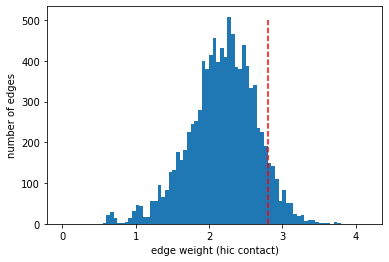

In [165]:
# Adjacency matrix to edge list
adj_mat = contacts_df2_tf.loc[selected_tf_loci,selected_adhesome_loci]
edge_list = adj_mat.stack().reset_index()
edge_list.columns = ['locus1','locus2','hic']
edge_list = edge_list[edge_list['hic']>0]
plt.figure()
plt.hist(edge_list['hic'].values, bins=np.arange(0,4.2,0.05))
plt.vlines(x=2.8, ymin=0, ymax=500, color='red', linestyle='dashed')
plt.xlabel('edge weight (hic contact)')
plt.ylabel('number of edges')
plt.show()

In [166]:
# Put lower threshold on HiC values
edge_list = edge_list[edge_list['hic']>2.8]
edge_list['vertex_set'] = [str(np.sort([edge_list.iloc[i]['locus1'], edge_list.iloc[i]['locus2']])) for i in range(len(edge_list))]
edge_list = edge_list.drop_duplicates(subset=['vertex_set'])
print('Total number of edges = '+str(len(edge_list)))

Total number of edges = 386


In [167]:
# Create network
network = nx.from_pandas_edgelist(edge_list, 'locus1', 'locus2', ['hic'])
print('Total number of nodes in network = '+str(len(network.nodes)))
print('Total number of edges in network = '+str(len(network.edges)))
print('Average node degree in network = '+str(np.mean(list(dict(network.degree).values()))))
print('Number of connected components in network = '+str(nx.number_connected_components(network)))
print('Size of connected components = '+str([len(c) for c in nx.connected_components(network)]))
print('Distribution of edge weights')

Total number of nodes in network = 113
Total number of edges in network = 386
Average node degree in network = 6.831858407079646
Number of connected components in network = 1
Size of connected components = [113]
Distribution of edge weights


In [168]:
# For each locus, also express it by the corresponding genes
adhesome_gene_id_ls = []
tf_gene_id_ls = []
locus_gene_list = []
locus_adhesome_gene_list = []
locus_tf_gene_list = []
for locus in tqdm(list(network.nodes)):
    time.sleep(.01)
    # Select chromosome
    chrom = 'chr'+locus.split('_')[1]
    df_loc_chrom = df_loc[df_loc['#chrom']==chrom]
    # Find genes and create gene ID for the locus
    loc = int(locus.split('_')[3])
    genes0 = df_loc_chrom.loc[(df_loc_chrom['chromStart']//resol)*resol == loc,'geneSymbol'].values
    genes1 = df_loc_chrom.loc[(df_loc_chrom['chromEnd']//resol)*resol == loc,'geneSymbol'].values
    genes2 = df_loc_chrom.loc[((df_loc_chrom['chromStart']//resol)*resol < loc) & 
                             ((df_loc_chrom['chromEnd']//resol)*resol > loc),'geneSymbol'].values
    genes = np.unique(list(itertools.chain.from_iterable([genes0,genes1,genes2])))
    adhesome_genes = [gene for gene in genes if gene in adhesome_genes_list]
    tf_genes = [gene for gene in genes if gene in tfs_targeting_adhesome_genes]
    locus_gene_list.append(genes)
    locus_adhesome_gene_list.append(adhesome_genes)
    locus_tf_gene_list.append(tf_genes)
    adhesome_gene_id = ''+"_".join(adhesome_genes)
    tf_gene_id = ''+"_".join(tf_genes)
    adhesome_gene_id_ls.append(adhesome_gene_id)
    tf_gene_id_ls.append(tf_gene_id)

100%|██████████| 113/113 [00:02<00:00, 55.99it/s]


In [172]:
node_attributes = pd.DataFrame({'locus_id': list(network.nodes),
                                'chr': [[int(locus.split('_')[1])] for locus in list(network.nodes)],
                                'adhesome_gene_id': adhesome_gene_id_ls,
                                'tf_gene_id': tf_gene_id_ls,
                                'locus_gene_list': locus_gene_list,
                                'locus_adhesome_gene_list': locus_adhesome_gene_list,
                                'locus_tf_gene_list': locus_tf_gene_list,
                                'has_genes': [len(gene_ls) for gene_ls in locus_gene_list],
                                'has_adhesome_genes': [len(gene_ls) for gene_ls in locus_adhesome_gene_list],
                                'has_tf_genes': [len(gene_ls) for gene_ls in locus_tf_gene_list]})
node_attributes = node_attributes.set_index('locus_id')
node_attributes.head()

,chr,adhesome_gene_id,tf_gene_id,locus_gene_list,locus_adhesome_gene_list,locus_tf_gene_list,has_genes,has_adhesome_genes,has_tf_genes
locus_id,,,,,,,,,
chr_1_loc_9750000,[1],,CTNNBIP1,"[CLSTN1, CTNNBIP1, LZIC, PIK3CD]",[],[CTNNBIP1],4,0,1
chr_11_loc_750000,[11],CD151,,"[AK126635, AP2A2, AX747537, CD151, CEND1, CHID...",[CD151],[],18,1,0
chr_1_loc_25000000,[1],,RUNX3,"[CLIC4, RUNX3]",[],[RUNX3],2,0,1
chr_8_loc_144750000,[8],PLEC,,"[AX746851, BREA2, CCDC166, EPPK1, FAM83H, LOC1...",[PLEC],[],14,1,0
chr_9_loc_133500000,[9],ABL1,,"[ABL1, AX748265, EXOSC2, FUBP3, PRDM12]",[ABL1],[],5,1,0


In [170]:
# Annotate graph
nx.set_node_attributes(network, {locus: str(node_attributes.loc[locus,'chr'][0]) for locus in network.nodes}, 'chromosome')
nx.set_node_attributes(network, {locus: node_attributes.loc[locus,'adhesome_gene_id'] for locus in network.nodes}, 'adhesome_gene_id')
nx.set_node_attributes(network, {locus: node_attributes.loc[locus,'tf_gene_id'] for locus in network.nodes}, 'tf_gene_id')
nx.set_node_attributes(network, {locus: node_attributes.loc[locus,'adhesome_gene_id']+'_'+node_attributes.loc[locus,'tf_gene_id'] for locus in network.nodes}, 'adh_tf_gene_id')
nx.set_node_attributes(network, {locus: float(node_attributes.loc[locus,'has_genes']) for locus in network.nodes}, 'number_of_genes')
nx.set_node_attributes(network, {locus: node_attributes.loc[locus,'locus_gene_list'].tolist() for locus in network.nodes}, 'gene_list')
nx.set_node_attributes(network, {locus: float(node_attributes.loc[locus,'has_adhesome_genes']) for locus in network.nodes}, 'number_of_adhesome_genes')
nx.set_node_attributes(network, {locus: str(node_attributes.loc[locus,'has_adhesome_genes']>0) for locus in network.nodes}, 'has_adhesome_genes')
nx.set_node_attributes(network, {locus: node_attributes.loc[locus,'locus_adhesome_gene_list'] for locus in network.nodes}, 'adhesome_gene_list')
nx.set_node_attributes(network, {locus: float(node_attributes.loc[locus,'has_tf_genes']) for locus in network.nodes}, 'number_of_tf_genes')
nx.set_node_attributes(network, {locus: str(node_attributes.loc[locus,'has_tf_genes']>0) for locus in network.nodes}, 'has_tf_genes')
nx.set_node_attributes(network, {locus: node_attributes.loc[locus,'locus_tf_gene_list'] for locus in network.nodes}, 'tf_gene_list')

In [171]:
# Save network to html
oi.output_networkx_graph_as_interactive_html(network, filename=saving_dir+"fig2_network.html")

PosixPath('/home/louiscam/projects/gpcr/save/figures/fig2_network.html')

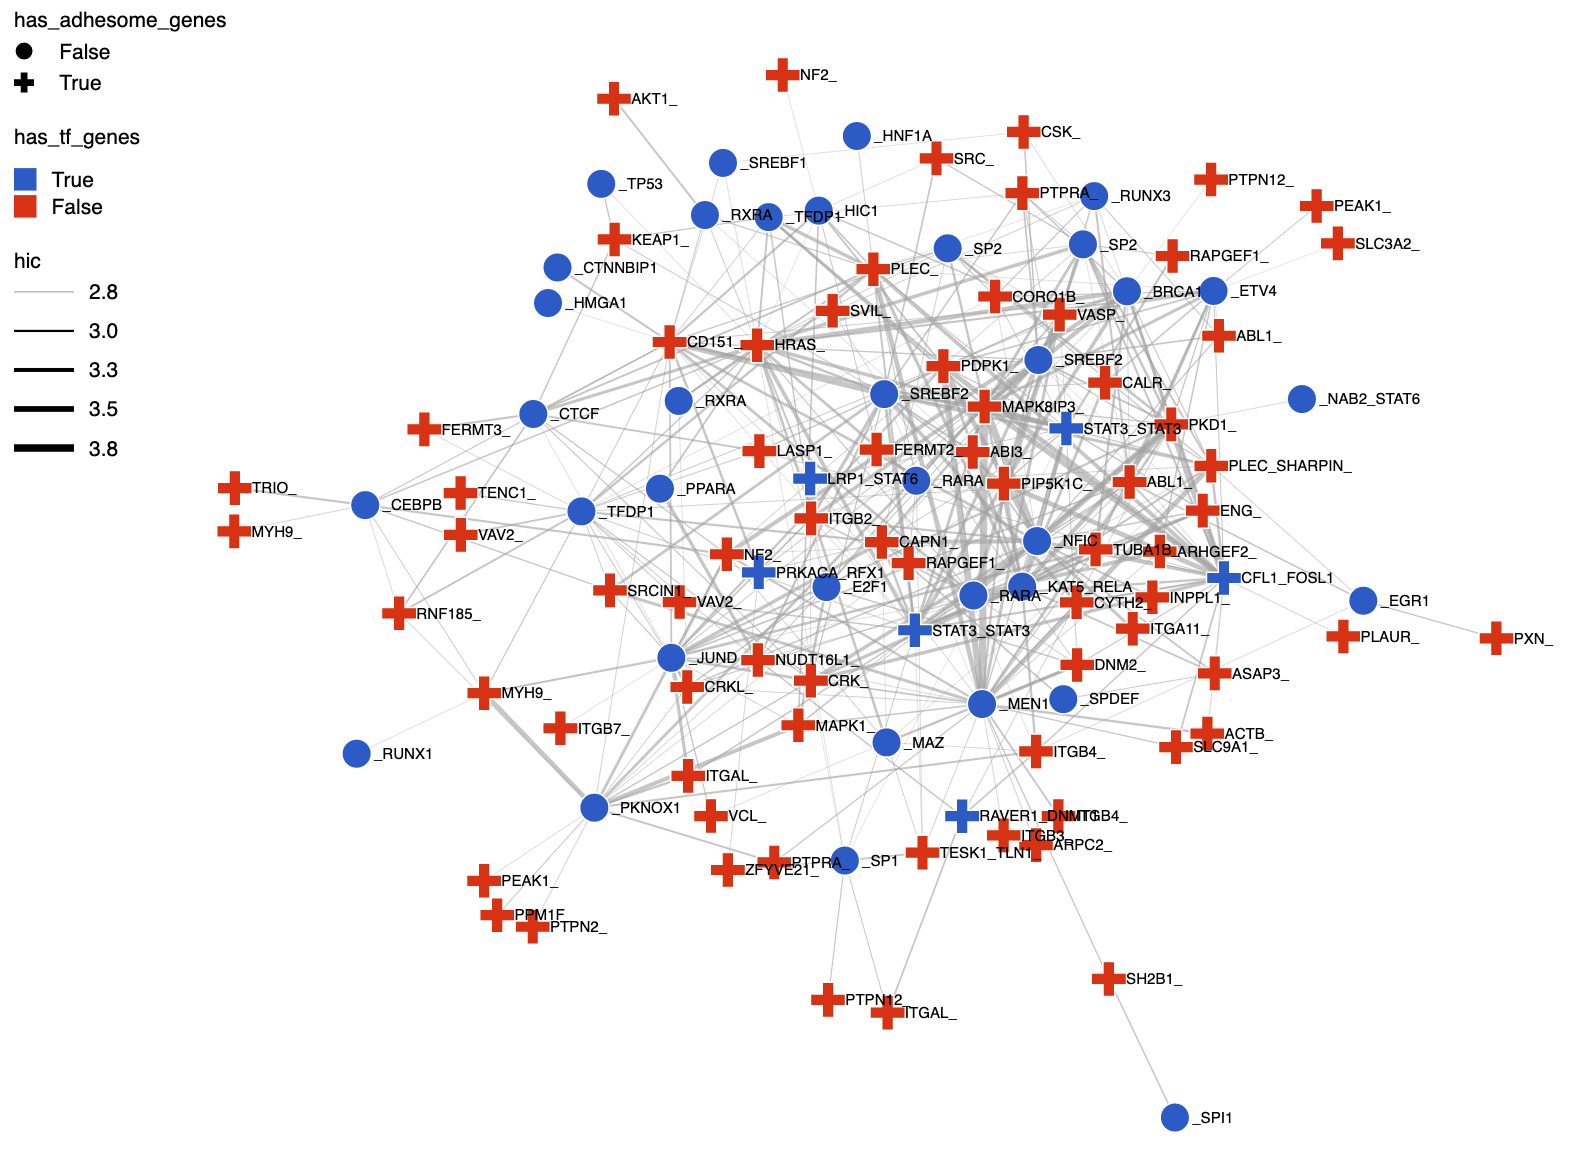

<span class="mark">ToDo</span>
- <span class="mark">Check that this is not a bipartite graph adn that I am adding all the edges required</span>
- <span class="mark">We need to find triangles, so drop all nodes that have degree 1</span>
- <span class="mark">Do clustering (using Louvain or correlation clustering)</span>